## Importing libraries, reading and understanding the data

In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('whitegrid')

train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')

from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (RandomForestClassifier,  
                              GradientBoostingClassifier,
                              VotingClassifier)
from sklearn.model_selection import cross_val_score,StratifiedKFold,GridSearchCV

In [68]:
train.shape, test.shape

((891, 12), (418, 11))

In [69]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [70]:
##filtering only numeric atributes
train_num=list(train.select_dtypes(exclude='object'))
train_num

['PassengerId', 'Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']

In [71]:
##filtering only categoric atributes
train_cat=list(train.select_dtypes(include='object'))
train_cat

['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked']

## Univariate Analysis

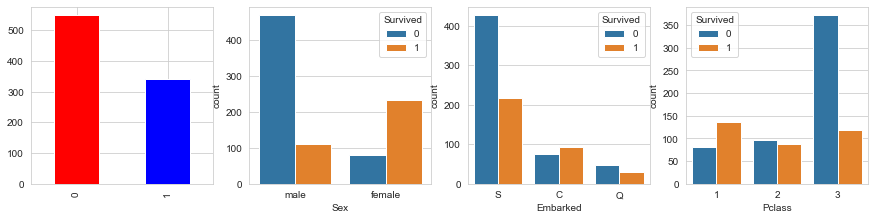

In [72]:
##Understanding the data and relevant columns
plt.subplot(441)
train['Survived'].value_counts().plot.bar(figsize=(15,15),color=['r','b'])
plt.subplot(442)
sns.countplot(x='Sex', data=train, hue='Survived')
plt.subplot(443)
sns.countplot(x='Embarked', data=train, hue='Survived')
plt.subplot(444)
sns.countplot(x='Pclass', data=train, hue='Survived');


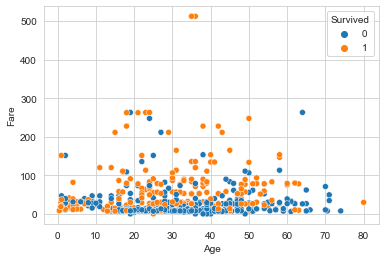

In [73]:
sns.scatterplot(x='Age', y='Fare', data=train, hue='Survived')
plt.show()  #obs: the 2 outliers will be excluded latter

## Adjusting the data

#### Treating the name column

In [74]:
#Let's check if the title is relevant
titles = [title[1][:-1] for title in train['Name'].str.split(" ")]
train['Title'] = titles
titles = [title[1][:-1] for title in test['Name'].str.split(" ")]
test['Title'] = titles

In [75]:
train['Title'].value_counts().tail()

Shawah        1
Pelsmaeker    1
de            1
Jonkheer      1
Velde         1
Name: Title, dtype: int64

In [76]:
train['Title'].fillna('Q', inplace=True)

In [77]:
#Here I decided to agroup the title in five categories: Mr, Miss, Mrs, Master and Others, to avoid model complexity, since these are the main categories.
titles=['Mr', 'Mrs', 'Miss', 'Dr', 'Ms']
for x in range(len(train['Title'])):
    if train['Title'][x] not in titles:
        train['Title'][x]='Other'
for x in range(len(test['Title'])):
    if test['Title'][x] not in titles:
        test['Title'][x]='Other'


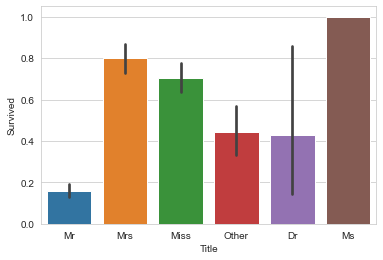

In [78]:
sns.barplot(x = train[:len(train)]['Title'], y = train['Survived']);

Conclusion: title is relevant and will be used in the model.

#### Excluding useless columns

In [79]:
train['Cabin'].value_counts()

C23 C25 C27    4
B96 B98        4
G6             4
C22 C26        3
D              3
              ..
A19            1
C90            1
B73            1
B19            1
A24            1
Name: Cabin, Length: 147, dtype: int64

In [80]:
ids=test['PassengerId']
train.drop(['Cabin','PassengerId','Name','Ticket'], axis=1, inplace=True)
test.drop(['Cabin','PassengerId','Name','Ticket'], axis=1, inplace=True)

#too much different values, so these columns aren't much useful.

#### Treating null values

In [81]:
train.isnull().sum()

Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Embarked      2
Title         0
dtype: int64

In [82]:
train['Embarked'].fillna('Q', inplace=True)
test['Embarked'].fillna('Q', inplace=True)
#replacing by Q since this is the category that have a closer suvivor distribution
# when compared to the overall survivor distribution.

In [83]:
#I must substitute the null values at the age column. let's see it's correlations:
train.corr()['Age']

Survived   -0.077221
Pclass     -0.369226
Age         1.000000
SibSp      -0.308247
Parch      -0.189119
Fare        0.096067
Name: Age, dtype: float64

In [84]:
#The correlation between age and 'survived' isn't that high, so I decided to just fill the null values with the mean age.
#Another option would be using it's correlation with Pclass to fill it's null values.
#Discarding the column isn't a good option since people aged under 10 have a considerable higher chance to survive.
train=train.fillna(train['Age'].mean())
test=test.fillna(train['Age'].mean())

#### Making dummy columns

In [85]:
train=pd.get_dummies(train, drop_first=True)
test=pd.get_dummies(test, drop_first=True)

#### Excluding outliers

In [86]:
train=train[train['Fare']<500]

## Model Building

In [87]:
X=train.drop(columns='Survived')
y=train['Survived']

I will use the following models:

Logistic Regression, 
SVC, 
Decision Tree, 
Random Forest,
Gradient Descent, 
K-Nearest Neighbors

In [100]:
log_reg = LogisticRegression(penalty='l2',C = 10)
svc = svm = SVC()
decision_tree = DecisionTreeClassifier()
rand_forest = RandomForestClassifier()
grad_desc = GradientBoostingClassifier()
knn = KNeighborsClassifier()
names=['log_reg','svc','decision_tree','rand_forest','grad_desc','knn']
models=[log_reg,svc,decision_tree,rand_forest,grad_desc,knn]


#### Testing each model performance:

In [90]:
kfold = StratifiedKFold(n_splits = 10)
def model_perf(model, X_train, y_train):
    cv_scores = cross_val_score(model, X, y, n_jobs = 4, cv = kfold, scoring = 'accuracy')
    mean = cv_scores.mean()
    std = cv_scores.std()
    
    return mean, std

In [91]:
def run_all(models, models_name):
    
    models_mean = []
    models_std = []
    
    for model in models:
        mean, std = model_perf(model, X, y)
        models_mean.append(mean)
        models_std.append(std)
        
    results = pd.DataFrame({"Model_Name" : models_name, "Mean_score" : models_mean, "STD_score" : models_std})
    
    return results

In [92]:
run_all(models,names)

,Model_Name,Mean_score,STD_score
0,log_reg,0.814211,0.027489
1,svc,0.680222,0.049011
2,decision_tree,0.779379,0.047092
3,rand_forest,0.806359,0.038976
4,grad_desc,0.833376,0.042127
5,knn,0.720787,0.035763


So I decided to exclude the svc classifier and make a voting classifier with the others.

#### Hyperparameter tunning:

In [93]:
models_grid = {
    "SVC" : {
        "model" : SVC(),
        "parameters" : {
            'C': [0.1, 1, 10, 100, 267, 1000], 
            'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
            'kernel': ['rbf']
        }
    },
    
    "RandomForest" : {
        "model" : RandomForestClassifier(),
        "parameters" : {
            "max_depth": [None],
            "max_features": [1, 3, 10],
            "min_samples_split": [2, 3, 10],
            "min_samples_leaf": [1, 3, 10],
            "bootstrap": [False, True],
            "n_estimators" :[100,300, 500],
            "criterion": ["gini"]
        }
    },
    
    "KNN" : {
        "model" : KNeighborsClassifier(),
        "parameters" : {
            "n_neighbors" : [5, 10, 20, 27],
            "weights" : ["uniform", "distance"],
            "algorithm" : ["auto", "ball_tree", "brute"]
        }
    },
    
     "LogisticRegression" : {
         "model" : LogisticRegression(),
         "parameters" : {
             "penalty" : ["l1", "l2", "elasticnet"],
             "solver" : ["newton-cg", "lbfgs", "liblinear", "sag"]
         }
     },
    
    "DecisionTree" : {
        "model" : DecisionTreeClassifier(),
        "parameters" : {
            
        }
    },
    
    "GradientBoosting" : {
        "model" : GradientBoostingClassifier(),
        "parameters" : {
            'loss' : ["deviance"],
            'n_estimators' : [100,200,300],
            'learning_rate': [0.1, 0.05, 0.01],
            'max_depth': [3,6,9],
            'min_samples_leaf': [1,50,100],
            'max_features': [None,0.3, 0.1] 
        }
    },    
    
    
    
    
    
}

In [48]:
scores = []
params = []
best_estimators = []
for estimator_info in models_grid.keys():
    estimator = models_grid[estimator_info]
    grid_srch = GridSearchCV(estimator = estimator['model'], param_grid = estimator['parameters'], 
                             scoring = 'accuracy', n_jobs = 4, cv = kfold)
    grid_srch.fit(X, y)
    scores.append(gftyyyyyrid_srch.best_score_)
    params.append(grid_srch.best_params_)
    best_estimators.append(grid_srch.best_estimator_)

In [94]:
pd.DataFrame({"Model_Name" : models_grid.keys(), "Model_score" : scores, "Model_params" : params})


,Model_Name,Model_score,Model_params
0,SVC,0.814275,"{'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}"
1,RandomForest,0.844688,"{'bootstrap': True, 'criterion': 'gini', 'max_..."
2,KNN,0.735432,"{'algorithm': 'auto', 'n_neighbors': 10, 'weig..."
3,LogisticRegression,0.816496,"{'penalty': 'l2', 'solver': 'lbfgs'}"
4,DecisionTree,0.770365,{}
5,GradientBoosting,0.841279,"{'learning_rate': 0.05, 'loss': 'deviance', 'm..."


So I decided to use the GradientBoosting classifier to make the prediction:

#### Making the prediction

In [101]:
grad_desc = GradientBoostingClassifier(learning_rate=0.05,loss='deviance',max_depth=9,max_features=0.3,min_samples_leaf=50,n_estimators=300)

In [102]:
grad_desc.fit(X,y)

GradientBoostingClassifier(learning_rate=0.05, max_depth=9, max_features=0.3,
                           min_samples_leaf=50, n_estimators=300)

In [103]:
submission_predictions = pd.Series(grad_desc.predict(test), name="Survived")
submission_df = pd.DataFrame({"Survived" : submission_predictions, "PassengerId" :ids})
submission_df.to_csv("submission.csv", index=False)

In [104]:
submission_df

,Survived,PassengerId
0,0,892
1,0,893
2,0,894
3,0,895
4,1,896
...,...,...
413,0,1305
414,1,1306
415,0,1307
416,0,1308
